## Regularization
### Ridge Regression
The main problem here is to solve the overfit, while in underfit you could add more epochs, training data,... In the overfit we should do another approach

Basically a overfit model would memorize the pattern too well on the train data, and not generalizing it to test data

$y_{i} = intercept + slope * x_{i}$

In the linear regression we try to minimize the sum of the square residuals (the distance between the line and the point)

In Ridge Regression we try to minimize the sum of $\lambda * slope^2$ and sum of square residuals

When the slope is small then is less sensitive, and viceversa

So when we try to minimize the slope for the final line, it means we're trying to let the model know that y is less sensitive to x, giving it a penalty

The $\lambda$ can be any number from 0 and above. When = 0, the penalty does nothing, when = huge number then the y will be less sensitive to x

How to get the optimal $\lambda$? we can try the cross validation a few time and get the one with lowest variance

Note: cross validation splits the data into: train, test, valid, the valid helps to check if the model is actually learning or memorizing by giving it a test during the training

What if we have more than x?

Then all the parameters would be summed, so:

$$
J(\Theta_{0},\Theta_{1}) = \frac{1}{2m} \sum_{i = 1}^{m} [(h_{\Theta}(x^{i}) - \^{y}^{i}) ^ {2} + \lambda \sum_{j = 1}^{m} \Theta_{j}^2]
$$

Every parameter is scaled ($slope* x{i}$), exept the intercept, so that's why we don't include it

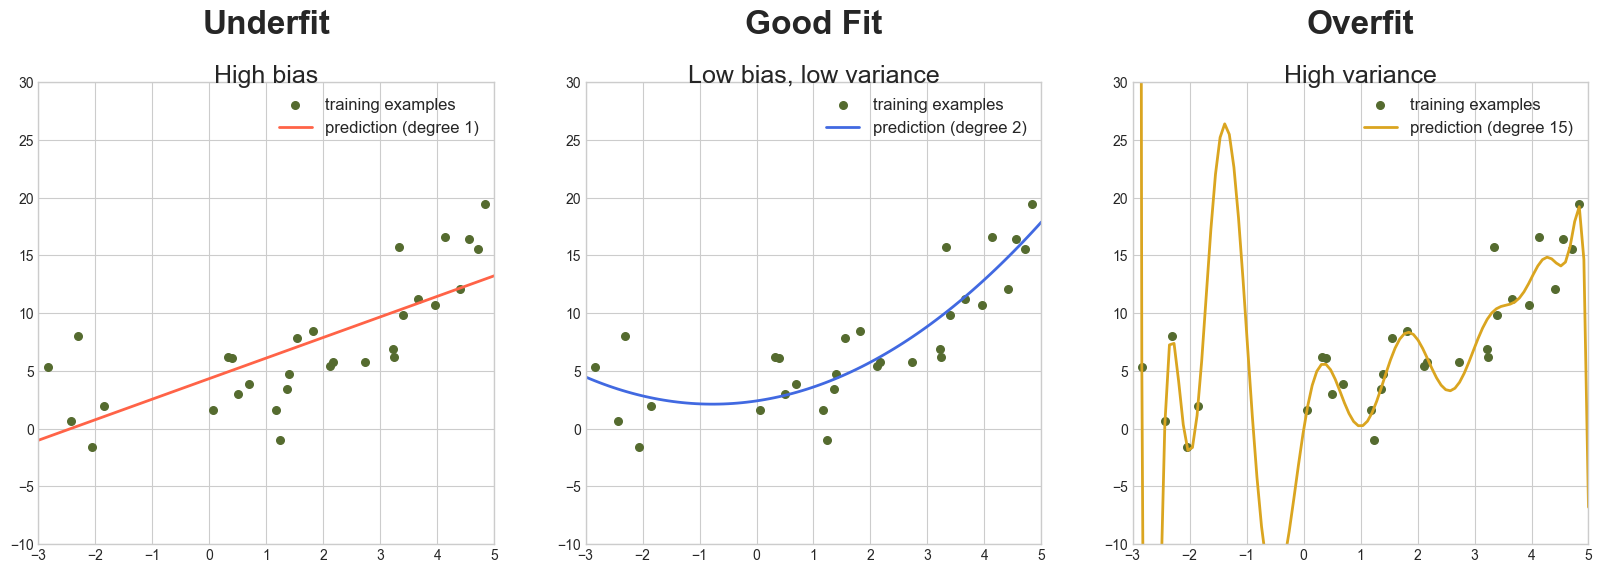

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')

np.random.seed(0)  # for reproducibility
n_samples = 30

true_fun = lambda X: 0.5 * X**2 + 1 * X + 2
# Generate X values and add random noise to the corresponding Y values
X = np.sort(np.random.rand(n_samples) * 8 - 3) # X from -3 to 5
y = true_fun(X) + np.random.randn(n_samples) * 2.5

# Reshape X for scikit-learn
X = X[:, np.newaxis]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define degrees, titles, and colors for the three plots
degrees = [1, 2, 15]
titles = ["Underfit", "Good Fit", "Overfit"]
subtitles = ["High bias", "Low bias, low variance", "High variance"]
colors = ['tomato', 'royalblue', 'goldenrod']

for i, degree in enumerate(degrees):
    ax = axes[i]
    
    # Create and fit the polynomial regression model
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("linear_regression", LinearRegression())
    ])
    pipeline.fit(X, y)
    
    # Create a smooth set of X values for plotting the prediction curve
    X_plot = np.linspace(-3, 5, 100)[:, np.newaxis]
    y_plot = pipeline.predict(X_plot)
    
    # Plot the training examples and the prediction curve
    ax.scatter(X, y, color='darkolivegreen', s=30, label="training examples")
    ax.plot(X_plot, y_plot, color=colors[i], linewidth=2, label=f"prediction (degree {degree})")
    
    # Set titles, subtitles, and axis limits
    ax.set_title(titles[i], fontsize=24, fontweight='bold', pad=35)
    ax.text(0.5, 1.0, subtitles[i], transform=ax.transAxes, ha='center', fontsize=18)
    ax.set_xlim(-3, 5)
    ax.set_ylim(-10, 30)
    ax.legend(loc='upper right', fontsize='large')

plt.show()

Lambda: 0.001 , Average CV MSE: 282.14
Lambda: 0.01  , Average CV MSE: 263.84
Lambda: 0.1   , Average CV MSE: 175.91
Lambda: 1     , Average CV MSE: 210.22
Lambda: 5     , Average CV MSE: 297.19
Lambda: 10    , Average CV MSE: 323.84
Lambda: 20    , Average CV MSE: 341.15
Lambda: 50    , Average CV MSE: 353.40
Lambda: 100   , Average CV MSE: 357.87

--- Cross-Validation Complete ---
Optimal Lambda found: 0.1

--- Final Performance on Hold-Out Test Set ---
Tuned Ridge Regression Test MSE:     70.56


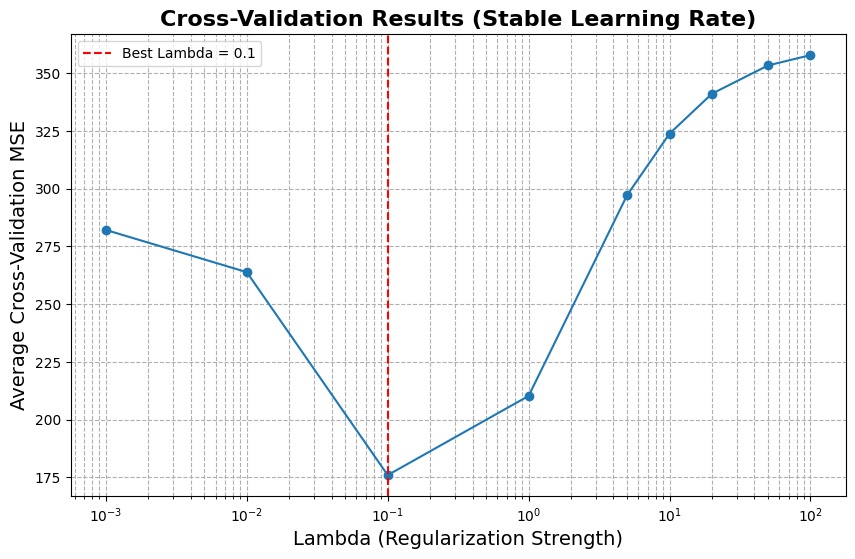

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

class RidgeRegression:
    def __init__(self, alpha, iter, lambda_param):
        self.alpha = alpha
        self.iter = iter
        self.lambda_param = lambda_param
        self.w = None
        self.b = None
    def fit(self, X, y):
        n_sample, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.iter):
            y_pred = np.dot(X, self.w) + self.b
            dw_mse = (2/n_sample) * np.dot(X.T, (y_pred - y))
            dw_penalty = 2 * self.lambda_param * self.w
            dw = dw_mse + dw_penalty
            db = (2/n_sample) * np.sum(y_pred - y)
            self.w -= self.alpha * dw 
            self.b -= self.alpha * db
    def predict(self, X):
        return np.dot(X, self.w) + self.b
        
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

np.random.seed(42)
n_samples = 50
n_features_real = 2
n_features_noise = 28
total_features = n_features_real + n_features_noise
X_real = np.random.rand(n_samples, n_features_real) * 10
y = 2.5 * X_real[:, 0] + 6.3 * X_real[:, 1] + np.random.randn(n_samples) * 3
X_noise = np.random.randn(n_samples, n_features_noise) * 5
X = np.concatenate((X_real, X_noise), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lambdas_to_test = [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100]
K = 5 # Number of folds
kfold = KFold(n_splits=K, shuffle=True, random_state=42)

STABLE_ALPHA = 0.001
STABLE_ITER = 5000

cv_scores = []
for lam in lambdas_to_test:
    fold_scores = []
    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Use the stable alpha and iter
        model = RidgeRegression(alpha=STABLE_ALPHA, iter=STABLE_ITER, lambda_param=lam)
        model.fit(X_train_fold, y_train_fold)
        
        val_preds = model.predict(X_val_fold)
        fold_mse = mse(y_val_fold, val_preds)
        fold_scores.append(fold_mse)
    
    avg_cv_score = np.mean(fold_scores)
    cv_scores.append(avg_cv_score)
    print(f"Lambda: {lam:<6}, Average CV MSE: {avg_cv_score:.2f}")

best_lambda_index = np.argmin(cv_scores)
best_lambda = lambdas_to_test[best_lambda_index]
print("\n--- Cross-Validation Complete ---")
print(f"Optimal Lambda found: {best_lambda}")

final_ridge_model = RidgeRegression(alpha=STABLE_ALPHA, iter=STABLE_ITER, lambda_param=best_lambda)
final_ridge_model.fit(X_train_scaled, y_train)
final_ridge_mse = mse(y_test, final_ridge_model.predict(X_test_scaled))

print("\n--- Final Performance on Hold-Out Test Set ---")
print(f"Tuned Ridge Regression Test MSE:     {final_ridge_mse:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(lambdas_to_test, cv_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Average Cross-Validation MSE', fontsize=14)
plt.title('Cross-Validation Results (Stable Learning Rate)', fontsize=16, fontweight='bold')
plt.grid(True, which="both", ls="--")
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best Lambda = {best_lambda}')
plt.legend()
plt.show()

### Lasso Regression
Instead of squaring the slope we take the absolute value, then we have lasso regression
$$J(\Theta_{0},\Theta_{1}) = \frac{1}{2m} \sum_{i = 1}^{m} [(h_{\Theta}(x^{i}) - \^{y}^{i}) ^ {2} + \lambda \sum_{j = 1}^{m} |\Theta{j}|]$$

So it's very similar to ridge regression, so what's the difference

The key here is that the Lasso can reach 0, while in the ridge you can only approach, not getting to 0

How this affects?

So assuming we're trying to predict the y by the formula
$$ y = intercept(b) + \Theta_{1} x_{1} + \Theta_{2} x_{2} + \Theta_{3} x_{3} + \Theta_{4} x_{4}$$

So let's assume $x_{3}$ and $x_{4}$ isn't that relevant to the y, with
- ridge $\Theta$ would never reach 0, so it still affects
- lass $\Theta$ would reach 0, then cancel out $x_{3}$ and $x_{4}$